# Imports:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from fastai.vision import *
from PIL import Image
import os

# PyTorch works best as a low-level foundation library, providing the basic operations for higher level functionality. 
# The fastai library is the most popular library for adding this higher-level functionality on top of PyTorch. 


In [2]:
# Fashion MNIST dataset is stored in .csv files. Let's read them as a pandas table:

path = '/kaggle/input'
mnist_train = pd.read_csv(path+'/fashionmnist/fashion-mnist_train.csv')
mnist_test = pd.read_csv(path+'/fashionmnist/fashion-mnist_test.csv')

# mnist_train's head:
mnist_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
mkdir'/kaggle/working/train'

In [4]:
mkdir'/kaggle/working/test'

In [5]:
# result = Image.fromarray(np.uint8(np.stack(mnist_test.iloc[0,1:].to_numpy().reshape((28,28))*3,axis=-1))) 
# result.save('../kaggle/working/train/'+str(0)+'.png')

In [6]:
# we need to convert pixel values and store it as images to be able to benefit from fastai library ImageDataBunch loader. So, here's the function:
# if your dataset is stored as images, you can skip this step. If not,you can modify this function.

def csv2img(csv,path='/kaggle/working/train/'): 
    """
    Convert pixel values from .csv to .png image
    """
    for i in range(len(csv)):
        # csv.iloc[i,1:].to_numpy() returns pixel values array for i'th imag excluding the label 
        # next step: reshape the array to original shape(28,28) and add missing color channels 
        result = Image.fromarray(np.uint8(np.stack(np.rot90(csv.iloc[i,1:].to_numpy().reshape((28,28)))*3,axis=-1))) 
        # save the image:
        result.save(path+str(i)+'.png')
    print(f'{len(csv)} images were created.')

# let's run the fuction:
csv2img(mnist_train)
csv2img(mnist_test,path='/kaggle/working/test/')

60000 images were created.
10000 images were created.


In [7]:
# check if the num of images in df and in the folder match: 
len(os.listdir('/kaggle/working/train')) == len(mnist_train)

True

In [8]:
# let's add text labels to the pandas table, we will use them for model training. 

dict_fashion = {
0:'T-shirt/top',
1:'Trouser',
2:'Pullover',
3:'Dress',
4:'Coat',
5:'Sandal',
6:'Shirt',
7:'Sneaker',
8:'Bag',
9:'Ankle boot'}

mnist_train['label_text'] = mnist_train['label'].apply(lambda x: dict_fashion[x])
mnist_test['label_text'] = mnist_test['label'].apply(lambda x: dict_fashion[x])

# add image names:
mnist_train['img'] = pd.Series([str(i)+'.png' for i in range(len(mnist_train))])
mnist_test['img'] = pd.Series([str(i)+'.png' for i in range(len(mnist_test))])


In [9]:
# save corresponding labels and image names to .csv file:
mnist_train[['label_text','img']].to_csv('/kaggle/working/labels.csv',index=False)
mnist_test[['img','label_text']].to_csv('/kaggle/working/test.csv',index=False)

# Init main objects:

### fastai can be used to solve different types of problems: collab. filtering, vision, text, tabular. More info: https://docs.fast.ai/applications.html#data
### In each case (except for collab filtering), the module is organized this way:

- **transform:**
  This sub-module deals with the pre-processing (data augmentation for images, cleaning for tabular data, tokenizing and numericalizing for text).

-  **data:**
   This sub-module defines the dataset class(es) to deal with this kind of data.

-  **models:**
   This sub-module defines the specific models used for this kind of data.

-  **learner:**
   When it exists, this sub-module contains functions that will directly bind this data with a suitable model and add the necessary callbacks.
   
Source: https://docs.fast.ai/applications.html#data

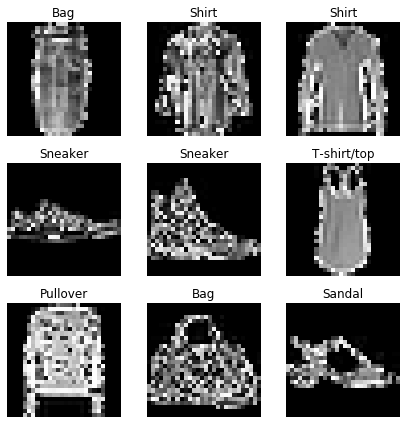

In [14]:
# Here, we load our images using the information stored in 'labels.csv': 'img' column includes image names; 'label_text' column includes lables.
# There are different ways to load the data into fastai's DataLoader, for more details please see the link: https://docs.fast.ai/data_block.html

data = (ImageList.from_csv('/kaggle/working/', 'labels.csv', folder='train')
        #Where to find the data? -> in '/kaggle/working/train' folder
        .split_by_rand_pct(seed=12)
        #How to split in train/valid? -> randomly with the default 20% in valid. There's an option to split by folfder or by id
        .label_from_df()
        #How to label? -> use the second column of the csv file and split the tags by ' '. / can be labeled by subfolder name/ can be labeled by applying regex to image name
        #.transform(tfms)
        #Data augmentation? -> use tfms with a size of 28. 
        .databunch() # change batch size and number of workers by passing arguments: (bs=32, num_workers=4, collate_fn=bb_pad_collate)
        #Finally -> use the defaults for conversion to databunch
        #.normalize()
       )   
        # Normalize x with mean and std, If you're using a pretrained model, you'll need to use the normalization that was used to train the model (e.g., imagenet_stats)

# Show image batch:
data.show_batch(rows=3, figsize=(6,6))


#################################
# one image:
# img,label = data.train_ds[5365]
# img
# define ImageDataBunch: 
# data = ImageDataBunch.from_df(path = '/kaggle/working/train/',df = mnist_train[['img','label_text']], seed = 12)

In [16]:
# choose estimator and metrics:

learn = cnn_learner(data, models.resnet34, metrics=[accuracy])

# available metrics: error_rate,accuracy, and others: https://docs.fast.ai/metrics.html

# available model architectures: https://docs.fast.ai/vision.models.html
# pretrained weights: True by default
# last layer removed and replaced new layer(head) with randomized weights, of an appropriate size for the dataset.


# Train the model:

In [17]:
# Initial training:

learn.fit_one_cycle(4)

"""
What is fit one cycle approach? 
shortly: this way of training the network reduces the training time and improves performance.

1. We progressively increase our learning rate from lr_max/div_factor to lr_max and at the same time we progressively decrease our momentum from mom_max to mom_min.
2. We do the exact opposite: we progressively decrease our learning rate from lr_max to lr_max/div_factor and at the same time we progressively increase our momentum from mom_min to mom_max.
3. We further decrease our learning rate from lr_max/div_factor to lr_max/(div_factor x 100) and we keep momentum steady at mom_max.

Source: https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?
paper: https://arxiv.org/pdf/1803.09820.pdf 
"""


epoch,train_loss,valid_loss,accuracy,time
0,1.003518,0.801153,0.696583,00:35
1,0.713258,0.604591,0.762667,00:35
2,0.593959,0.531945,0.799083,00:35
3,0.564394,0.504551,0.807417,00:34


In [28]:
def interpret_res(plot_top_losses=True, conf_matrix=True, most_confused=False):
    """
    Result interpretation includes top losses, confusion matrix, and most confused.
    """
    
    # plot top losses:
    if plot_top_losses==True:
        interp = ClassificationInterpretation.from_learner(learn)
        losses,idxs = interp.top_losses()
        len(data.valid_ds)==len(losses)==len(idxs)
        interp.plot_top_losses(9, figsize=(12,12))

    # plot confusion matrix:
    if conf_matrix==True:
        doc(interp.plot_top_losses)
        interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

    # most confused:
    if most_confused==True:
        interp.most_confused(min_val=100)

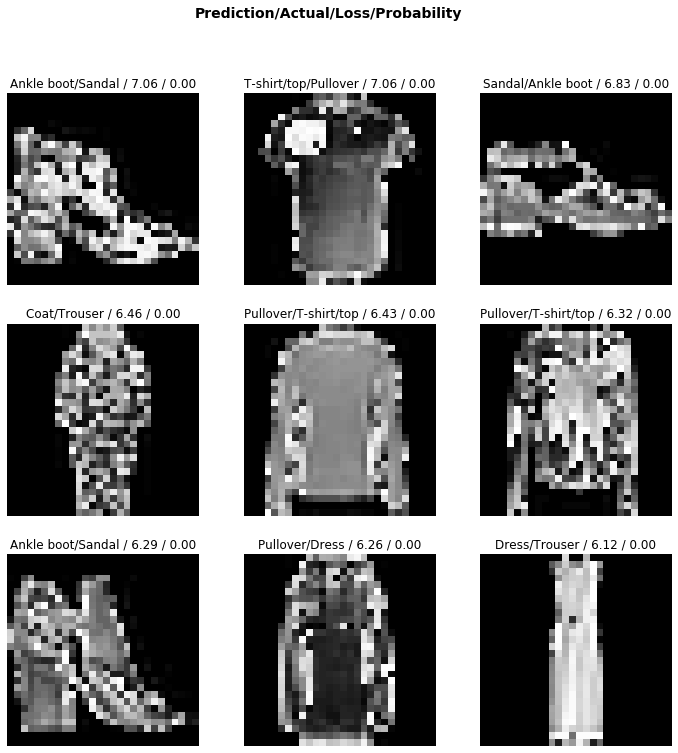

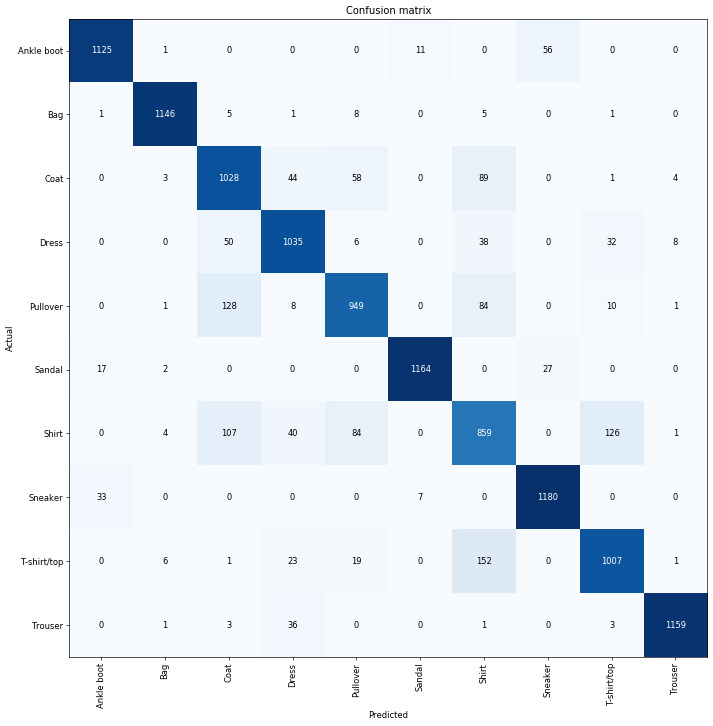

In [29]:
interpret_res()
# we can see that it's not obvious even for human to classify the image properly:

# Finetune the model:

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


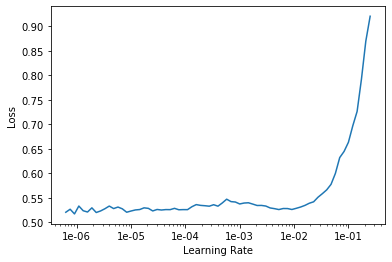

In [21]:
"""
Lets find the optimum learning rate for our comparison by doing an LR range test.
Learning rate finder: plots lr vs loss relationship to reduce the amount of guesswork on picking a good starting learning rate.
paper: https://arxiv.org/abs/1506.01186
"""

# we are looking for the sharpest downward slope range:
learn.lr_find()
learn.recorder.plot()

In [22]:
# unfreeze pre-trained weights and choose LR from previous step:

learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.491804,0.420796,0.840167,00:40
1,0.302405,0.302256,0.887667,00:40


In [25]:
# to save the model:
learn.save('resnet-temp')
# to load the model:
learn.load('resnet-temp');

In [30]:
learn_resnet50 = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy])


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


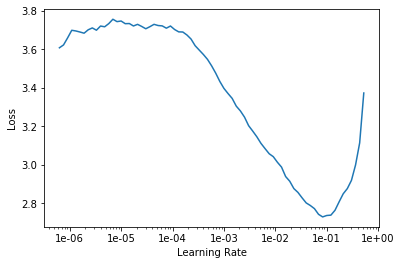

In [31]:
learn_resnet50.lr_find()
learn_resnet50.recorder.plot()

In [32]:
learn_resnet50.fit_one_cycle(8,max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.975216,0.850734,0.301083,0.698917,00:44
1,0.670421,0.576144,0.219583,0.780417,00:43
2,0.523472,0.468263,0.177167,0.822833,00:42
3,0.471417,0.443958,0.166750,0.833250,00:43
4,0.424855,0.392497,0.146333,0.853667,00:43
5,0.374943,0.382172,0.140583,0.859417,00:42
6,0.336146,0.375040,0.138000,0.862000,00:43
7,0.310589,0.376814,0.138417,0.861583,00:43


In [33]:
# let's save the weights. We can come back to this stage if during experimentation smth happens:
learn_resnet50.save('learn_resnet50')
learn_resnet50.load('learn_resnet50');

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


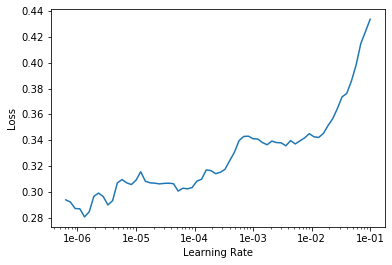

In [34]:
learn_resnet50.lr_find()
learn_resnet50.recorder.plot()

In [35]:
# unfreeze pre-trained weights:
# here, lr should be usually smaller than at the previous stage. Cuz we just need to fine-tune the weights, not to ruin them :)
learn_resnet50.unfreeze()
learn_resnet50.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.334097,0.399432,0.133917,0.866083,00:50
1,0.251794,0.336841,0.124167,0.875833,00:49


In [36]:
learn_resnet50.save('learn_resnet50_stage2')

In [37]:
# resnet50 has more weights and thus needs to be trained longer:
learn_resnet50.fit_one_cycle(3, max_lr=1e-5)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.233214,1.472068,0.133083,0.866917,00:53
1,0.181873,0.487196,0.127000,0.873000,00:50
2,0.143157,0.357773,0.124333,0.875667,00:50


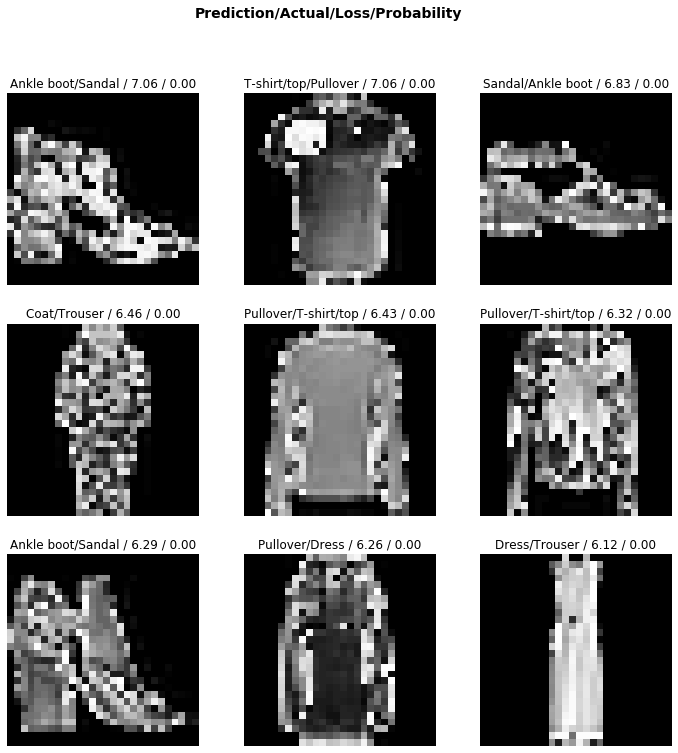

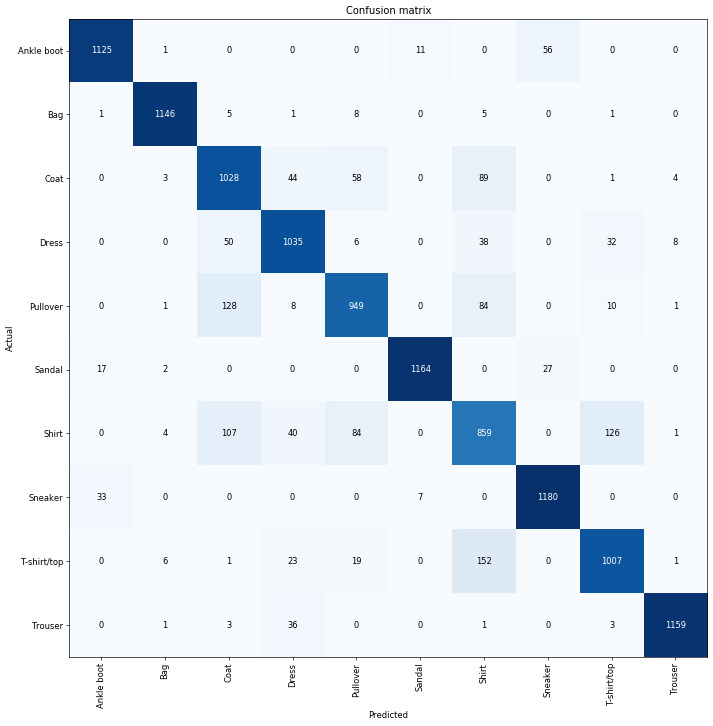

In [39]:
interpret_res()

# Data augmentation and normalization
**vision.transform** lets us do data augmentation. Simplest is to choose from a standard set of transforms, where the defaults are designed for photos:

In [40]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



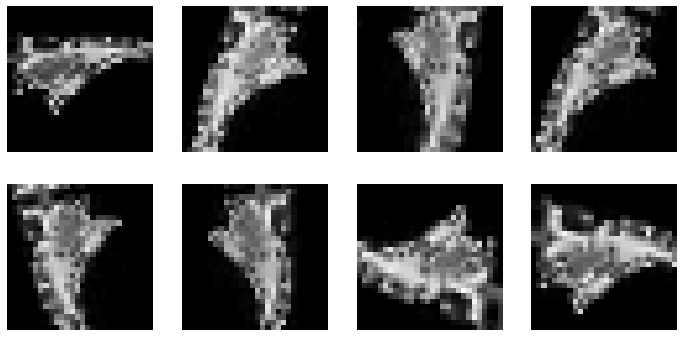

In [41]:
# Examples of image augmentaion:

tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=25)
def get_ex(): return open_image('/kaggle/working/train/1.png')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
    
plots_f(2, 4, 12, 6, size=28)

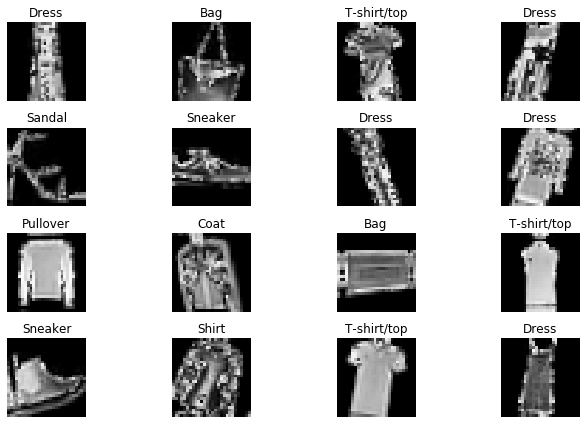

In [43]:
tfms = get_transforms(do_flip=False,max_rotate=20)

data = (ImageList.from_csv('/kaggle/working/', 'labels.csv', folder='train')
        .split_by_rand_pct(seed=12)
        .label_from_df()
        .transform(tfms)
        #Data augmentation? -> use tfms with a size of 28. Also, we can transform the image size adding another arg: (224,224)
        .databunch() 
        .normalize(imagenet_stats)
        # Normalize x with mean and std, If you're using a pretrained model, you'll need to use the normalization that was used to train the model (e.g., imagenet_stats)
       )   
        
    
data.show_batch(rows=4, figsize=(10,6))

In [47]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


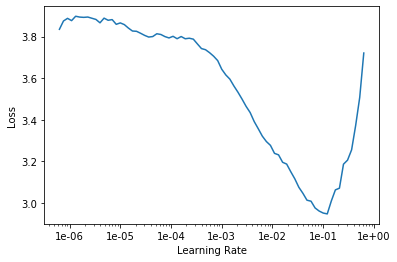

In [45]:
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(3, max_lr=slice(1e-3,1e-1))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.612102,2.370094,0.289667,0.710333,01:22
1,0.878175,0.616153,0.221667,0.778333,01:24
2,0.585719,0.517965,0.185167,0.814833,01:23


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


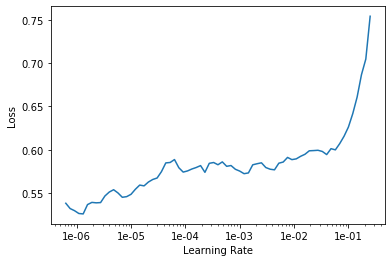

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.520372,0.416881,0.156417,0.843583,01:30
1,0.441291,0.374921,0.143583,0.856417,01:29


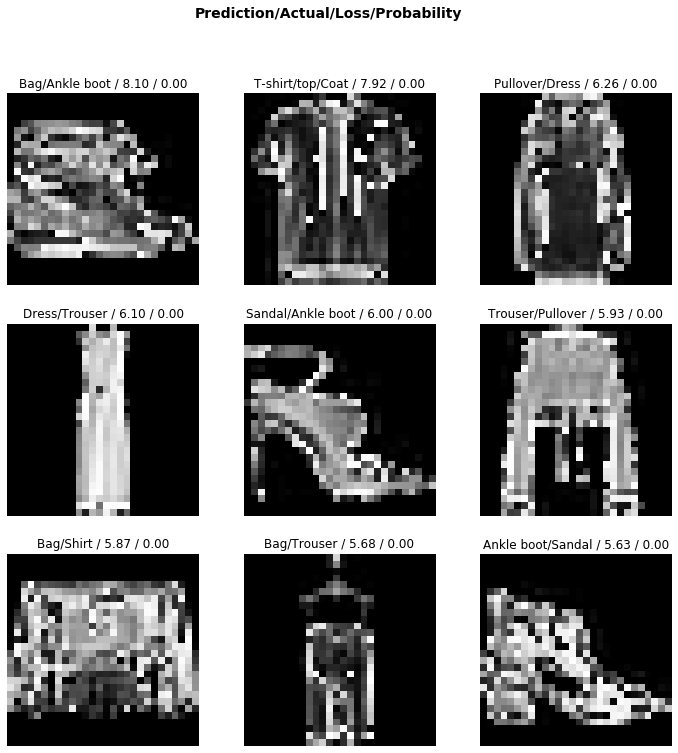

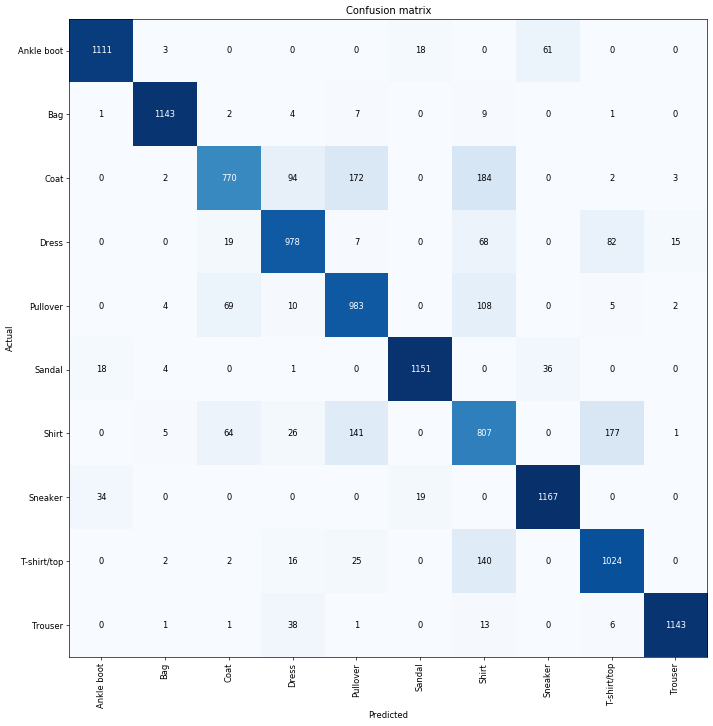

In [52]:
interpret_res()